One Machine against Infinite Bus (OMIB) simulation with [PowerSimulationsDynamics.jl](https://github.com/NREL-SIIP/PowerSimulationsDynamics.jl)

**Originally Contributed by**: Rodrigo Henriquez and José Daniel Lara

# Introduction

This tutorial will introduce you to the functionality of `PowerSimulationsDynamics`
for running power system dynamic simulations.

This tutorial presents a simulation of a two-bus system with an infinite bus
(represented as a voltage source behind an impedance) at bus 1, and a classic
machine on bus 2. The perturbation will be the trip of one of the two circuits
(doubling its resistance and impedance) of the line that connects both buses.

## Dependencies

In [1]:
using SIIPExamples #hide
using PowerSimulationsDynamics
using PowerSystems
using Sundials
using Plots
gr()

┌ Info: Precompiling PowerSimulationsDynamics [398b2ede-47ed-4edc-b52e-69e4a48b4336]
└ @ Base loading.jl:1278
┌ Info: Precompiling Sundials [c3572dad-4567-51f8-b174-8c6c989267f4]
└ @ Base loading.jl:1278
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


Plots.GRBackend()

`PowerSystems` (abbreviated with `PSY`) is used to properly define the data structure and establish an equilibrium
point initial condition with a power flow routine, while `Sundials` is
used to solve the problem defined in `PowerSimulationsDynamics`.

## Load the system
_The following command requires that you have executed the
[dynamic systems data example](../../notebook/2_PowerSystems_examples/loading_dynamic_systems_data.jl.ipynb)
previously to generate the json file._

In [2]:
file_dir = joinpath(
    dirname(dirname(pathof(SIIPExamples))),
    "script",
    "4_PowerSimulationsDynamics_examples",
    "Data",
)
omib_sys = System(joinpath(file_dir, "omib_sys.json"))

┌ Info: Loaded time series from storage file existing=omib_sys_time_series_storage.h5 new=/var/folders/27/2jr8c7gn4j72fvrg4qt81zrw8w_711/T/jl_SYKFVM
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/ZLiq3/src/hdf5_time_series_storage.jl:82
┌ Warning: Rate provided for BUS 1-BUS 2-i_2 is larger than the SIL Inf in the range of (min = 134.0, max = 145.0).
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/YyIFf/src/utils/IO/branchdata_checks.jl:147
┌ Warning: Rate provided for BUS 1-BUS 2-i_1 is larger than the SIL Inf in the range of (min = 134.0, max = 145.0).
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/YyIFf/src/utils/IO/branchdata_checks.jl:147
┌ Warning: struct DynamicGenerator does not exist in validation configuration file, validation skipped
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/ZLiq3/src/validation.jl:51
┌ Warning: struct DynamicGenerator does not exist in validation configuratio

,ConcreteType,SuperTypes
,String,String
1,Arc,Topology <: Component <: InfrastructureSystemsComponent <: InfrastructureSystemsType <: Any
2,Area,AggregationTopology <: Topology <: Component <: InfrastructureSystemsComponent <: InfrastructureSystemsType <: Any
3,Bus,Topology <: Component <: InfrastructureSystemsComponent <: InfrastructureSystemsType <: Any
4,"DynamicGenerator{BaseMachine,SingleMass,AVRFixed,TGFixed,PSSFixed}",DynamicInjection <: Device <: Component <: InfrastructureSystemsComponent <: InfrastructureSystemsType <: Any
5,Line,ACBranch <: Branch <: Device <: Component <: InfrastructureSystemsComponent <: InfrastructureSystemsType <: Any
6,LoadZone,AggregationTopology <: Topology <: Component <: InfrastructureSystemsComponent <: InfrastructureSystemsType <: Any
7,Source,StaticInjection <: Device <: Component <: InfrastructureSystemsComponent <: InfrastructureSystemsType <: Any
8,ThermalStandard,ThermalGen <: Generator <: StaticInjection <: Device <: Component <: InfrastructureSystemsComponent <: InfrastructureSystemsType <: Any


## Build the simulation and initialize the problem

The next step is to create the simulation structure. This will create the indexing
of our system that will be used to formulate the differential-algebraic system of
equations. To do so, it is required to specify the perturbation that will occur in
the system. `PowerSimulationsDynamics` supports three types of perturbations:

- Network Switch: Change in the Y-bus values.
- Branch Trip: Disconnects a line from the system.
- Change in Reference Parameter

Here, we will use a Branch Trip perturbation, that is modeled by modifying the
specifying which line we want to trip. In this case we disconnect one of the lines
that connects BUS 1 and BUS 2, named "BUS 1-BUS 2-i_1".

With this, we are ready to create our simulation structure:

In [3]:
time_span = (0.0, 30.0)
perturbation_trip = BranchTrip(1.0, "BUS 1-BUS 2-i_1")
sim = Simulation(pwd(), omib_sys, time_span, perturbation_trip)

┌ Info: Serialized time series data to /var/folders/27/2jr8c7gn4j72fvrg4qt81zrw8w_711/T/jl_IfMGF1/sys_time_series_storage.h5.
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/ZLiq3/src/time_series_storage.jl:55
┌ Info: Serialized System to /var/folders/27/2jr8c7gn4j72fvrg4qt81zrw8w_711/T/jl_IfMGF1/sys.json
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/YyIFf/src/base.jl:235
┌ Info: Loaded time series from storage file existing=sys_time_series_storage.h5 new=/var/folders/27/2jr8c7gn4j72fvrg4qt81zrw8w_711/T/jl_5t5zJE
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/ZLiq3/src/hdf5_time_series_storage.jl:82
┌ Warning: Rate provided for BUS 1-BUS 2-i_2 is larger than the SIL Inf in the range of (min = 134.0, max = 145.0).
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/YyIFf/src/utils/IO/branchdata_checks.jl:147
┌ Warning: Rate provided for BUS 1-BUS 2-i_1 is larger than the SIL Inf in the range of (m

Simulation()


This will automatically initialize the system by running a power flow
and update `V_ref`, `P_ref` and hence `eq_p` (the internal voltage) to match the
solution of the power flow. It will also initialize the states in the equilibrium,
which can be printed with:

In [4]:
print_device_states(sim)

Voltage Variables
BUS 1
Vm 1.05
θ -0.0
BUS 2
Vm 1.04
θ 0.0229
Differential States
generator-102-1
δ 0.1685
ω 1.0


To examine the calculated initial conditions, we can export them into a dictionary:

In [5]:
x0_init = get_initial_conditions(sim)

Dict{String,Any} with 5 entries:
  "generator-102-1" => Dict(:ω=>1.0,:δ=>0.168525)
  "V_R"             => Dict(102=>1.03973,101=>1.05)
  "Vm"              => Dict(102=>1.04,101=>1.05)
  "θ"               => Dict(102=>0.0228958,101=>-1.27016e-19)
  "V_I"             => Dict(102=>0.0238095,101=>-1.33367e-19)

## Run the Simulation

Finally, to run the simulation we simply use:

In [6]:
execute!(
    sim, #simulation structure
    IDA(), #Sundials DAE Solver
    dtmax = 0.02,
); #Arguments: Maximum timestep allowed

In some cases, the dynamic time step used for the simulation may fail. In such case, the
keyword argument `dtmax` can be used to limit the maximum time step allowed for the simulation.

## Exploring the solution

`PowerSimulationsDynamics` has two functions to obtain different
states of the solution:
 - `get_state_series(sim, ("generator-102-1", :δ))`: can be used to obtain the solution as
a tuple of time and the required state. In this case, we are obtaining the rotor angle `:δ`
of the generator named `"generator-102-1"`.

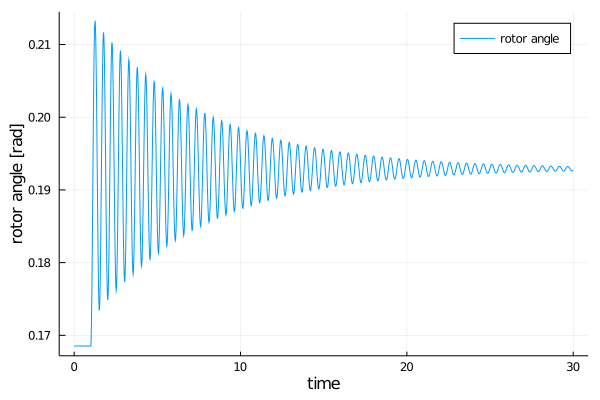

In [7]:
angle = get_state_series(sim, ("generator-102-1", :δ));
Plots.plot(angle, xlabel = "time", ylabel = "rotor angle [rad]", label = "rotor angle")

- `get_voltagemag_series(sim, 102)`: can be used to obtain the voltage magnitude as a
tuple of time and voltage. In this case, we are obtaining the voltage magnitude at bus 102
(where the generator is located).

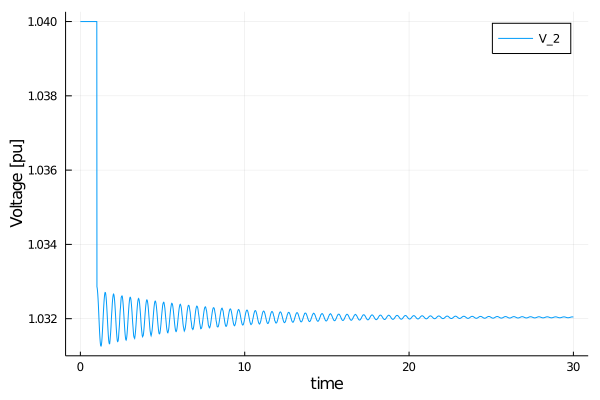

In [8]:
volt = get_voltagemag_series(sim, 102);
Plots.plot(volt, xlabel = "time", ylabel = "Voltage [pu]", label = "V_2")

## Optional: Small Signal Analysis

`PowerSimulationsDynamics` uses automatic differentiation to compute the reduced Jacobian
of the system for the differential states. This can be used to analyze the local stability
of the linearized system. We need to re-initialize our simulation:

In [9]:
sim2 = Simulation(pwd(), omib_sys, time_span, perturbation_trip)

small_sig = small_signal_analysis(sim2)

┌ Info: Serialized time series data to /var/folders/27/2jr8c7gn4j72fvrg4qt81zrw8w_711/T/jl_XdZVxs/sys_time_series_storage.h5.
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/ZLiq3/src/time_series_storage.jl:55
┌ Info: Serialized System to /var/folders/27/2jr8c7gn4j72fvrg4qt81zrw8w_711/T/jl_XdZVxs/sys.json
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/YyIFf/src/base.jl:235
┌ Info: Loaded time series from storage file existing=sys_time_series_storage.h5 new=/var/folders/27/2jr8c7gn4j72fvrg4qt81zrw8w_711/T/jl_DWacUS
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/ZLiq3/src/hdf5_time_series_storage.jl:82
┌ Warning: Rate provided for BUS 1-BUS 2-i_2 is larger than the SIL Inf in the range of (min = 134.0, max = 145.0).
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/YyIFf/src/utils/IO/branchdata_checks.jl:147
┌ Warning: Rate provided for BUS 1-BUS 2-i_1 is larger than the SIL Inf in the range of (m

The system is small signal stable


The `small_sig` result can report the reduced jacobian for ``\delta`` and ``\omega``,

In [10]:
small_sig.reduced_jacobian

2×2 Array{Float64,2}:
  0.0       376.991
 -0.466763   -0.317662

and can also be used to report the eigenvalues of the reduced linearized system:

In [11]:
small_sig.eigenvalues

2-element Array{Complex{Float64},1}:
 -0.15883100381194412 - 13.264252860693972im
 -0.15883100381194412 + 13.264252860693972im

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*